# Analyzing and Improving the Image Quality of StyleGAN (StyleGAN2)

- [Analyzing and Improving the Image Quality of StyleGAN
](https://arxiv.org/abs/1912.04958)

### Abstract
---
- StyleGAN의 문제를 분석하고, 모델의 구조와 학습 방법을 개선하였습니다.

- Generator 의 구조 개선
    - Redesign generator normalization: "Droplet artifacts" 문제 해결
    - Revisit progressive growing: "phase" artifacts, Shift-invariance of the network 문제 해결
    - Regularze the generator : 더 좋은 image와 latent vector의 대응 (smoother latent space W)
    - Capacity Increase: the effective resolution of the generated images.
    
- Generator에 Regularization 추가하여 더 좋은 image와 latent vector의 대응.

- Path length regularization (Perceptual Path Length의 활용)
    - 생성자가 역변환(projection from images to latent space)을 하기 쉽게 할 수 있습니다.
    - 주어진 이미지가 특정 네트워크에서 생성된 것인지 판별할 수 있습니다.(image forensics)

### 1. Introduction
---
- 기존의 styleGAN은 input latent code z ∈ Z 대신, mapping network f를 도입하였습니다.(intermediate latent code w ∈ W) 또한, Affine transform을 사용하여 style을 생성했으며 stochastic variation을 주기 위해 noise를 사용하였습니다.

#### Problem : 이미지의 feature map에서 계속해서 정체불명의 물방울무늬가 생김

-> StyleGAN2는 G의 normalization을 다시 디자인하여 물방울을 제거하고, Progressive Growing이 아닌 다른 training 방식을 사용하여 고해상도의 이미지를 생성하였습니다.

### 2. Removing normalization artifacts
---
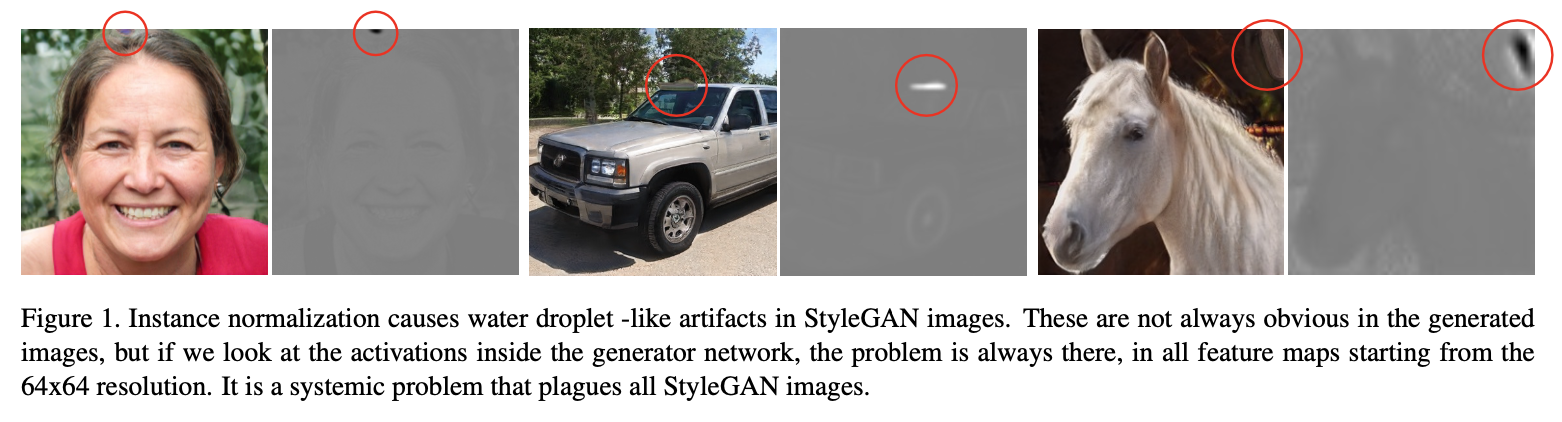

StyleGAN에서 생성 된 이미지들은 물방울과 같은 `blob-shaped artifacts` 가 생겼습니다. 이러한 현상은 모든 feature map에서 나타나며, 고 해상도의 이미지일수록 강하게 나타났었습니다.

#### 2-1 Generator architecture revisited
---
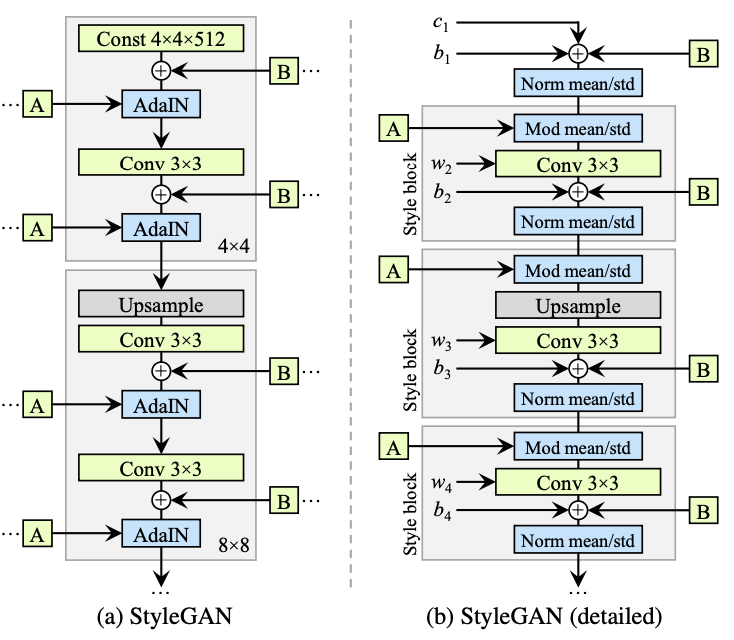

기존의 StyleGAN 은 style block 내에서 bias와 noise을 적용했었는데, 이 때문에 style이 오히려 현재 style의 크기에 반비례하게 적용되었다. `Stylegan2에서는 bias & noise를 styleblock 외부로 옮겨주어 이를 해결하였습니다.`

- Instance Normalization : AdaIN을 없애고 feature map마다 평균과 표준편차를 계산
    - AdaIN을 없애는 이유 : blob-shaped artifacts이 왜 생기는지에 대한 명확한 원인은 못찾았지만, 이는 AdaIN 때문에 생기는 것으로 저자들은 추측하였습니다. (StyleGAN에서 normalization를 없애니 물방울이 생기는 현상들이 사라지는 것을 발견하였습니다.) 따라서 StyleGAN2에서는 이를 제거하였다.

- modulation을 통해 scaling & biasing

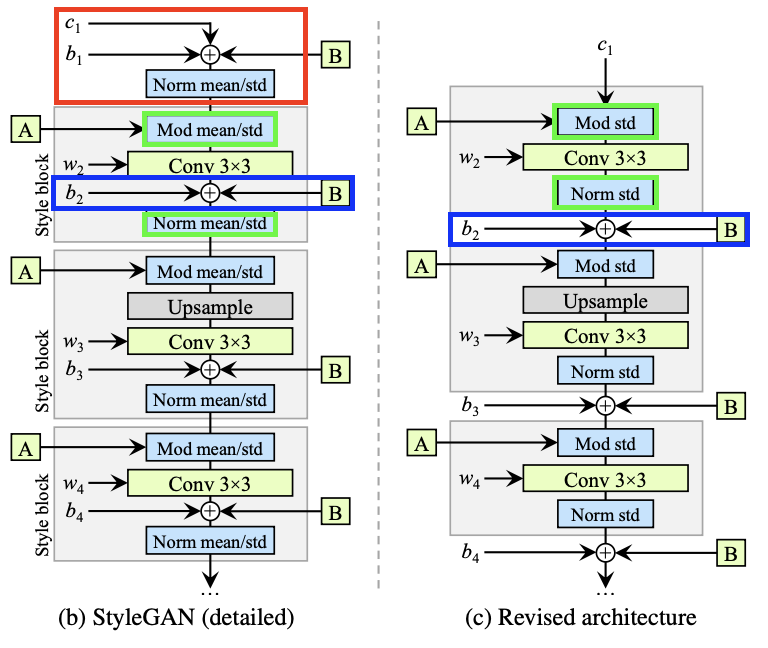

(b) -> (c)

- `Blue block` : noise를 더해주는 부분과 bias를 더해주는 부분을 normalization 이후로 옮겨 주었습니다. 

    - why? : noise는 보통 gaussian 정규분포에서 뽑는데, conv layer 이후에 이 값을 더해주면 noise의 값이 비교적 작으므로 이 영향이 반영되지 않을 수도 있다. 따라서 conv layer의 결과값을 normalize해준 후에 이 noise를 더해주었습니다.

- `Green block` : 저자들이 실험을 해보니 평균(mean)을 구하지 않고 표준편차(standard deviation)만을 사용하여도 normalization과 modulation을 할 수 있음을 확인할 수 있었습니다.
    - normalize를 해줄 때 mean값을 빼주는 과정을 안해줘도 됩니다.

- `Red block` : 초기의 Learned constant input에서 bias, noise, normalization을 해주지 않아도 별다른 성능 저하가 나타나지 않아서 이들도 제거해주었습니다.

#### 2-2. Instance normalization revisited
---

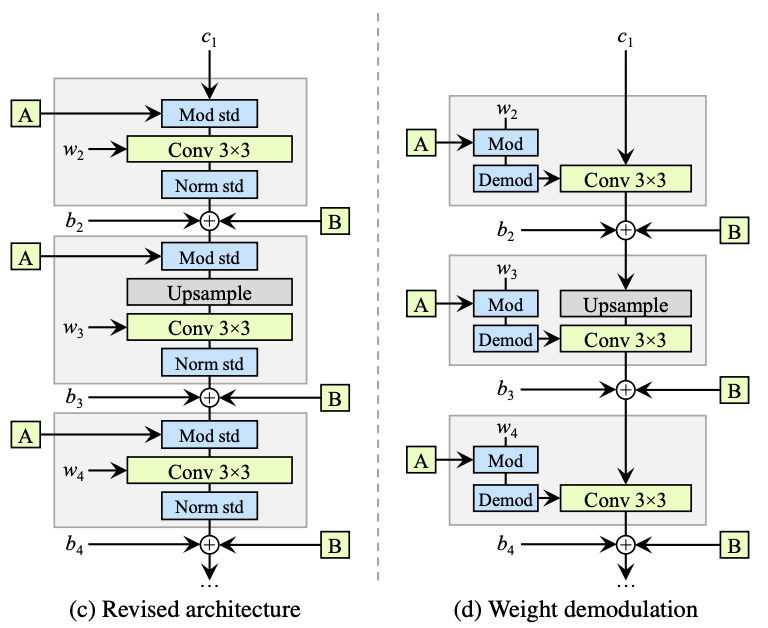

- (c) Revised architecture 는 Modulation, Convolution, Normalization으로 구성되어있습니다.

StyleGAN2의 최종 모델인 (d)에서는 각 feature map에서 modulation (scaling)을 하는 대신, convolutional weight에 modulation을 해주었다.

- weight를 modulation하는게 feature를 modulation하는 것보다 학습속도가 빠릅니다.

Modulation
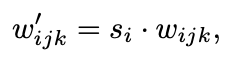

- Instance normalization은 output feature map이 scaling되지 않도록 정규화를 하는 과정입니다.(Variance를 1로 만드는 과정) StyleGAN2에서는 weight에 scaling을 하므로 conv 연산 후에도 scaling이 되어있지 않도록 convolution layer의 weight를 조정해주었습니다.

- 가정 : input feature map의 표준편차(standard deviation)는 1

modulation과 convolution 후에 표준편차는

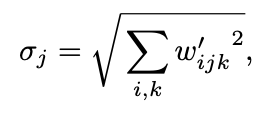

Demodulation : output feature map의 분산도 1이 되도록 다시 scaling을 해줍니다.

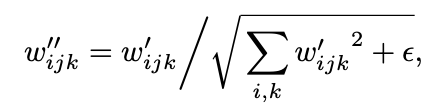

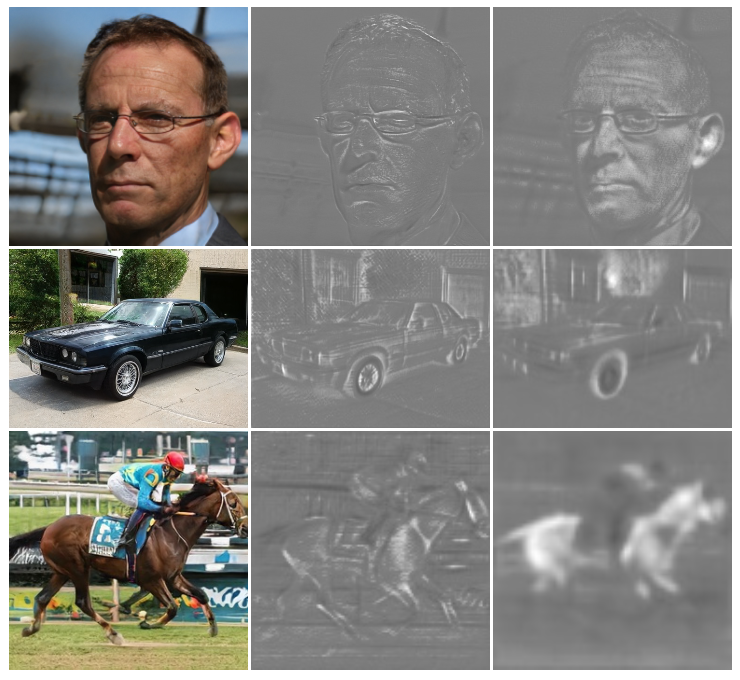

-> 생성 이미지에 물방울이 생기는 현상들이 사라졌음을 확인 할 수 있습니다.

> 정리) 기존 StyleGAN에서는 AdaIN이 feature map의 평균과 분산을 normalize했지만, StyleGAN2에서는 convolution weight를 normalize합니다.
>
> AdaIN에서 평균을 제거하고 표준편차만 사용하였고, 표준편차만으로도 충분하다는 것을 알게 되었습니다.
>
> 또한. bias와 noise를 block 외부로 빼서 style과 noise의 영향력을 독립시켰습니다.
>
>기존에는 noise의 영향력이 style의 크기에 반비례하였으나, noise의 변화에 따른 효과가 분명해졌습니다.
>
> 이는 Instance Normalization과 수학적으로 동일한 방법은 아니지만, output feature map을 standard unit standard deviation을 갖도록 해주어 학습을 더욱 안정적으로 만들며 아무튼 물방울 artifact를 없앴습니다. 

### 3. Image quality and generator smoothness
---
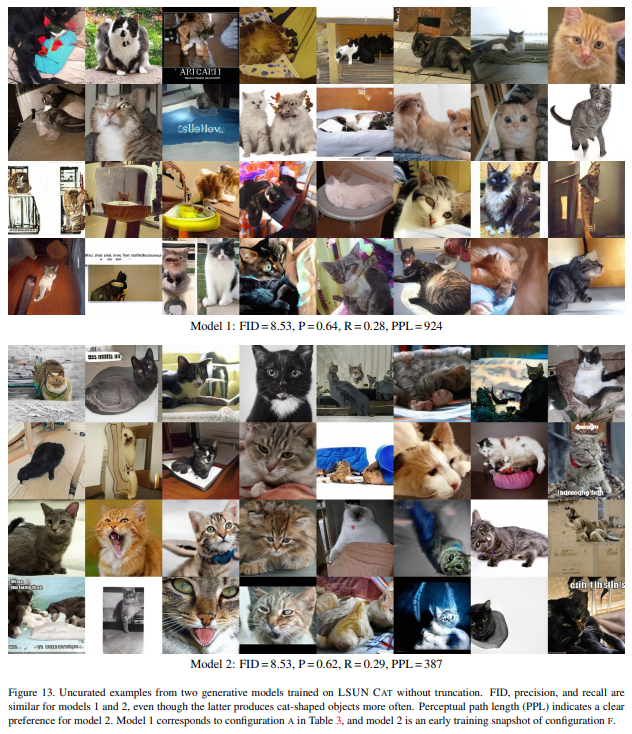

- FID나 P&R(Precision and Recall)이 같더라도 PPL이 낮은 사진이 질이 더 좋다고 합니다.

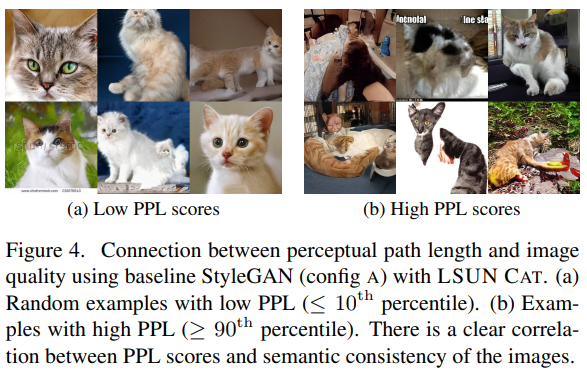

- PPL(Perceptual Path Length)이 낮을 수록 high-quality image를 만들어 줍니다.

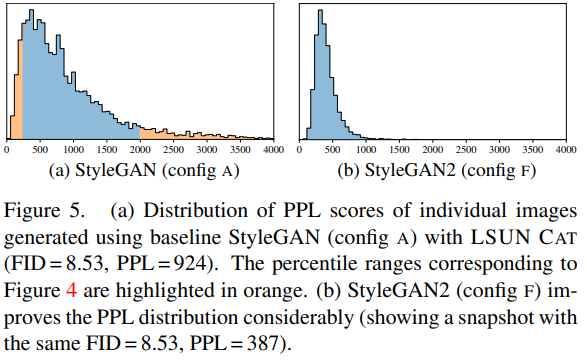

-> StyleGAN1에 비해 StyleGAN2의 PPL이 작음을 확인 할 수 있었습니다.

#### 3-1. Lazy regularization
---
StyleGAN은 non-saturated adversarial loss인 BCE loss와 R1 regularization을 사용했습니다.

- 보통 BCE loss와 R1 regularization의 조합을 많이 사용 

다만, StyleGAN 은 R1 regularization을 매 iteration마다 해주었다면, StyleGAN2에서는 computation cost를 줄이기 위해 R1 regularization을 매번 해주지는 않는다. (ex. 16 iteration에 한번)

이를 Lazy regularization이라고 부릅니다.

### 3-2. Path Length Regularization
---
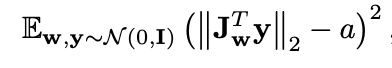

생성 네트워크가 생성한 이미지가 실제처럼 잘 생성되었는 지를 사람이 일일이 확인 하는 것은 힘들고, 사람마다 편향이 있어 객관적이지 못하다. 이에 따라 이미지의 퀄리티를 정량적으로 평가할 기준이 필요하다고 합니다. 일반적으로 generative model에 대하여 분류자(classifier) 기반의 Metric을 이용하였다고 합니다.

- Fréchet Inception Distance (FID score) : measures the differences in the density of two distributions in the high dimensional feature space of a InceptionV3 classifier

- Precision and Recall (P&R): provide additional visibility by explicitly quantifying the percentage of generated images that are similar to training data and the percentage of training data can be generated, respectively.

그러나, 위 두 metric (FID and P&R)은 다음과 같은 문제가 있었다.

- 사람은 구조적(shape) 으로 잘 생성되었는 지를 기준으로 판단하지만, 네트워크는 세밀한 texture가 실제 같은 지를 기준으로 판단합니다.

저자들은 StyleGAN에서 interpolation과 disentanglement의 정량적 평가로 사용하였던 perceptual path length (PPL)이 이미지의 구조적 일관성(consistency)과 안정성(stability)과 관련되어 있다는 것을 알게 되었다고 합니다.

원래 PPL은 이미지와 latent space 상에서의 대응 관계에 대한 smoothness를 측정하는 척도로 개발되었습니다. Latent space 상에서 노이즈를 추가하여 생성된 이미지들 상의 LPIPS distance를 측정하여 작은 값을 가질 수록 smooth하다고 하였다. 저자들은 이 현상을 잘 생성된 이미지들끼리는 좋은 latent space를 구성하였을 것이며, 잘못 생성된 이미지들(low-quality images)은 latent space상에서 작고 노이즈에 따른 변화가 큰 영역을 차지하고 있을 것이기 때문이라고 가정하였다.

> We hypothesize that during training, as the discriminator penalizes broken images, the most direct way for the generator to imporve is to effectively stretch the region of latent space that yields good images.

Path Length Regularization을 적용함으로써 이미지의 퀄리티가 좋아지고, 더 나아가, 이미지로부터 latent vector를 찾아내는 역과정(inverse mapping)이 쉬워졌다고 저자들은 주장하였습니다.

### 4. Progressive growing revisited
---
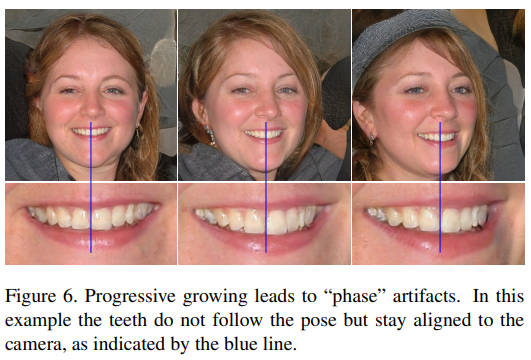

PGGAN은 고해상도의 이미지를 잘 생성하지만, Phase artifacts(strong location)문제 가 있습니다.

- Phase artifacts(strong location): 눈동자나 이빨의 모양은 잘 생성이 되지만, 자세를 바꿔도 치아의 위치가 고정됨을 위의 이미지를 보면 확인 할 수 있습니다.

PGGAN의 architecture를 따르는 StyleGAN 역시 동일한 문제가 생겨 StyleGAN2 에서는 이를 해결하고자 progressive growing의 학습방식을 채택하지 않았다.

#### 4-1 Alternative network architectures
---
Progressive growing의 방식을 따르지 않고도 high-quality의 이미지를 잘 생성할 수 있도록 저자들은 StyleGAN을 변형시켰습니다.

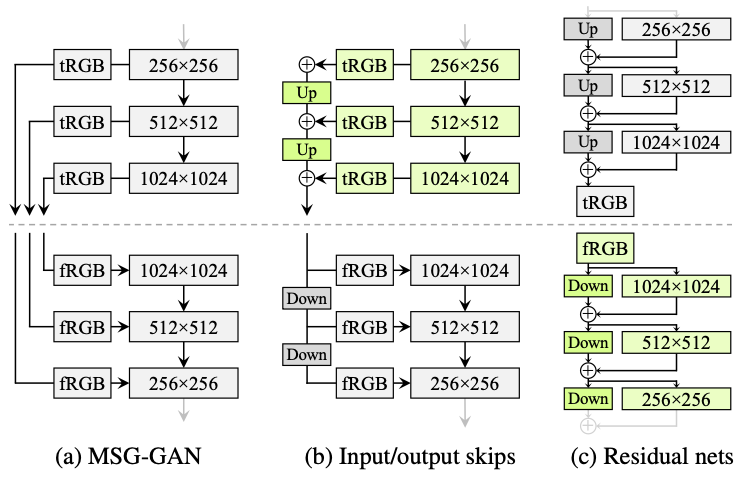

본 논문은 세가지의 Generator와 Discriminator의 architecture에 대해 실험을 했으며, 이 중 `skip generator와 residual discriminator의 방식으로 architecture를 구성하였습니다.`

#### 4-2 Resolution usagePermalink
---
Progresive Growing에서는 Generator가 low-resolution feature에 집중을 하다가 서서히 finer detail을 잡아가는 방식으로 학습을 한다면, 위의 StyleGAN에서는 G가 low-resolution의 이미지를 생성하다가 점차 high-resolution의 이미지를 생성하는 방식으로 학습을 진행하였습니다.

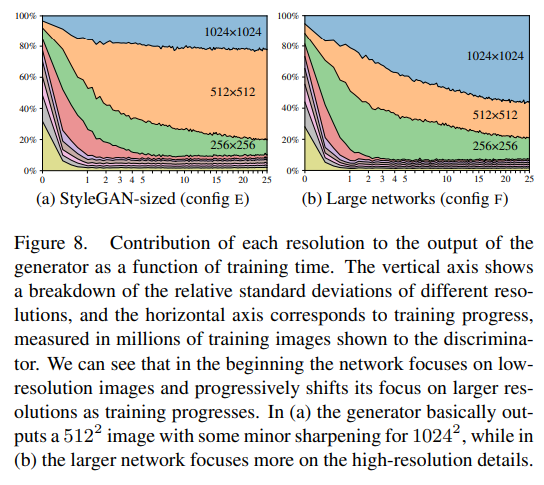

(b)는 (a)보다 channel의 수를 늘린 경우이다.

기존의 setting (a)에서는 고 해상도(1024)에서 filter의 영향력이 작아 variance가 작았다면, channel size를 늘렸을 때에는 generator가 high-resolution의 이미지를 생성할 수 있게 되었음을 그래프를 통해서 확인 할 수 있습니다.

### 5. Projection of images to latent space
---
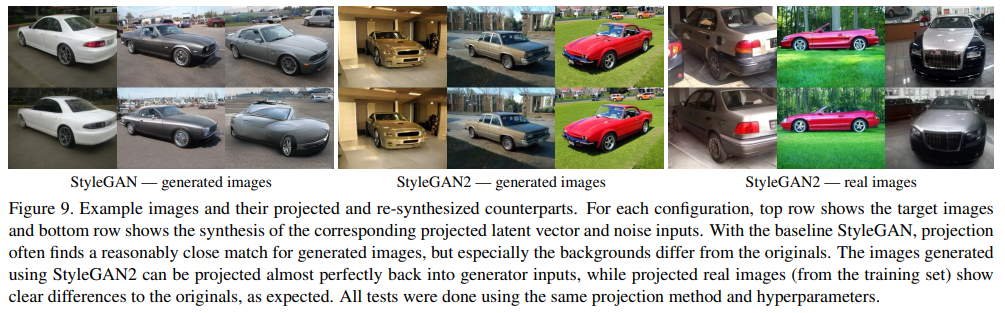

다음은 생성된 이미지를 latent space로 projection한 후에, 그 latent space를 이용해 다시금 이미지를 생성한 결과입니다.

- random init z에서 이미지를 생성한 후, target 이미지와 가장 비슷한 이미지의 latent space를 찾는 방식으로 projection을 함.

> StyleGAN은 자기 자신이 생성한 이미지에 대해서도 projection을 잘 못하지만, StyleGAN2는 자신이 생성한 이미지에 대해서는 latent space로 projection을 잘 시켜주었습니다.

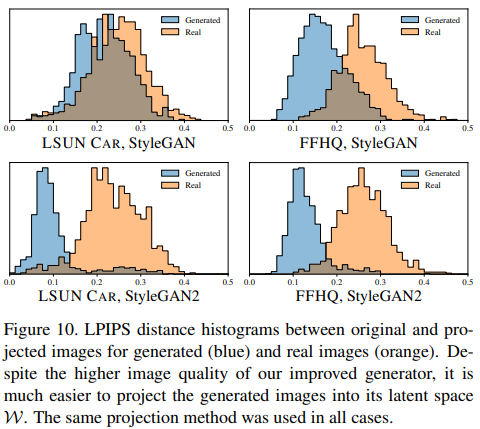

LPIPS distance를 계산해보면, StyleGAN은 real와 생성 이미지를 잘 구별 못하지만 StyleGAN2는 구별을 잘 하였음을 확인할 수 있습니다.

### 6. Conclusions and future work
---
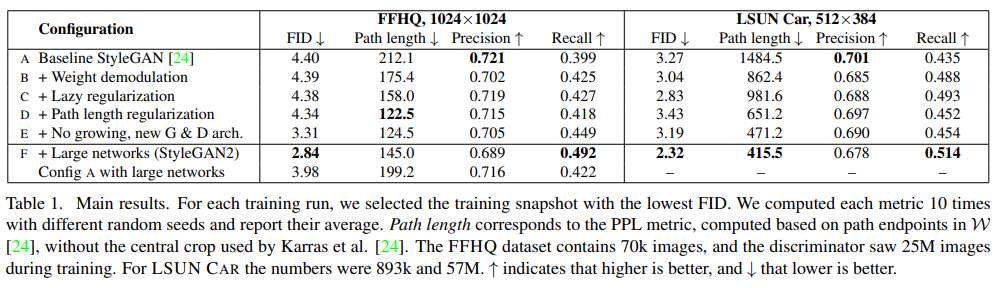

위에서 제시한 styleGAN2의 기법을 사용하면 성능이 좋아졌음을 확인 할 수 있습니다.

-> StyleGAN2는 StyleGAN의 architecture를 개선하여 blob-shaped artifacts문제를 해결하고 high-quality의 이미지를 생성하였다.